## **Automatic Filling of the Accident Report (Alec)**

This notebook performs the first stage of the project, which involves filling out the accident report form excluding the sketch drawing.  
This stage is divided into three main steps:

---

### 1. Automatic Text Extraction

Text is extracted from photos of official documents:

- ID card  
- Driver’s license  
- License plate  

Each piece of extracted information is saved into a corresponding `.txt` file for later use.

---

### 2. Interactive Questions with LLM

For details that cannot be inferred from documents (such as whether the client is injured or the policy number of the insurance),  
a Large Language Model (LLM) prompts the user with specific questions.

- "Are you injured?" 
- "Is there any property damage?"
- "What is your phone number?"
- "Can the insurance recover the VAT on the vehicle?"  
- "What is your insurance company?"  
- "What is the policy number of the insurance company?"  
- "Who is your agent?"  
- "Do you have a greencard? (If yes, what is the number?)"  
- "Until when is the greencard valid?"  
- "Is the damage to the vehicle insured?"

The user’s answers are also saved into text files.

---

### 3. Overlaying the Document (Vehicle A)

In this final step, all previously saved text files are imported.  
The extracted and user-provided data is then overlaid onto the official accident report form — specifically for Vehicle A.


## **1. Automatic Text Extraction**
---

### **Tesseract OCR vs Microsoft Azure Form Recognizer**

As following each input will use these pre-trained models and the results will be compared.  

##### **1: National Identity Document**
The ID card will be used to fill in **Section 6** of the accident report form, which relates to insurance details.  
Since insurance documents are not publicly available, we use the ID as a source of information.  
From the ID, we extract the following:
- **Full name**  
- **First name**  
- **Nationality** (used here to approximate the address)

##### **2: License Plate**

##### **3: Drivers License**
- **Full name**
- **First name**
- **License number**
- **Type of drivers license**



#### **1.1 National Identity Document Text Extraction**

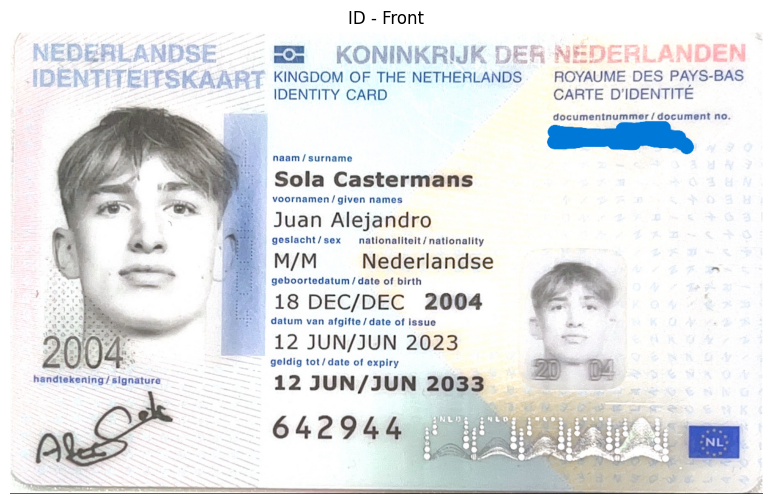

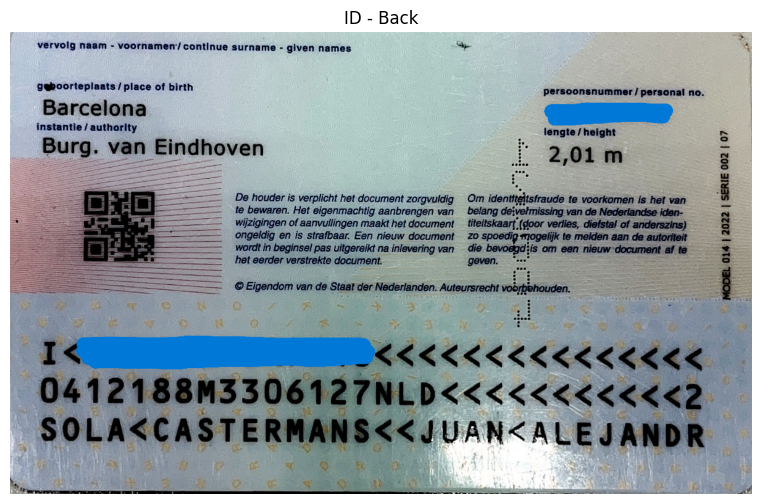

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Image paths
image_paths = [
    "../Text Extraction/Data/IdAlecFront.png",
    "../Text Extraction/Data/IdAlecBack.png"
]

# Display each image
for i, path in enumerate(image_paths):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"ID - {'Front' if i == 0 else 'Back'}")
    plt.show()

#### **Tesseract OCR**

This Python script processes front and back images of an ID card to extract structured information.

First, each image is cropped to keep only the middle third, where the relevant information is located. This reduces noise and helps Tesseract focus on the important area.

The script then extracts both the raw OCR text and structured fields (like name and date of birth), saving them to separate text files for later use

In [ ]:
import cv2
import pytesseract
import numpy as np
import re
import os
import matplotlib.pyplot as plt

# Paths to images
image_paths = [
    "../Text Extraction/Data/IdAlecFront.png",
    "../Text Extraction/Data/IdAlecBack.png"
]

# Output files
output_txt_fields = "../Text Extraction/Outputs/IDAlecTextExtraction.txt"
output_txt_full = "../Text Extraction/Outputs/IDAlecFullOutput.txt"

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")

    height, width = img.shape[:2]
    left = int(width * 0.35)
    right = int(width * 0.65)
    cropped = img[:, left:right]

    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub(r'[0O]', 'O', text)
    text = re.sub(r'[1I]', 'I', text)
    text = re.sub(r'\bIUN\b', 'JUN', text, flags=re.IGNORECASE)
    text = re.sub(r'\bDEC/DEC\b', 'DEC', text)
    text = re.sub(r'\bJUN/JUN\b', 'JUN', text)
    return text

def extract_fields(text):
    fields = {}
    text = clean_text(text)

    surname = None
    given_names = None

    surname_match = re.search(r'(?:naam|surname)[^\w]*([^\d:\/\n\r]+?)(?=(voornamen|given names|geslacht|sex|$))', text, re.IGNORECASE)
    if surname_match:
        surname = surname_match.group(1)
        surname = re.sub(r'\b(surname|voornamen|given names|geslacht)\b', '', surname, flags=re.IGNORECASE).strip()

    given_names_match = re.search(r'(?:voornamen|given names)[^\w]*([^\d:\/\n\r]+?)(?=(geslacht|sex|$))', text, re.IGNORECASE)
    if given_names_match:
        given_names = given_names_match.group(1)
        given_names = re.sub(r'\b(surname|voornamen|given names|geslacht)\b', '', given_names, flags=re.IGNORECASE).strip()

    if given_names:
        fields["IDfirst_name"] = given_names.title()
    if given_names and surname:
        full_name = f"{given_names} {surname}"
        fields["IDname"] = full_name.upper()

    lines = text.splitlines()
    for i, line in enumerate(lines):
        if re.search(r'\bgeboortedatum\b|\bdate of birth\b', line, re.IGNORECASE):
            if i + 1 < len(lines):
                next_line = clean_text(lines[i + 1])
                next_line = re.sub(r'\b([A-Z]{3})/\1\b', r'\1', next_line, flags=re.IGNORECASE)
                date_match = re.search(r'(\d{1,2})\s+([A-Z]{3})\s+(\d{4})', next_line)
                if date_match:
                    day, month, year = date_match.groups()
                    fields["date_of_birth"] = f"{int(day):02d} {month.upper()} {year}"
            break

    for line in lines:
        if re.search(r'(geslacht|sex).*?(nationaliteit|nationality)', line, re.IGNORECASE):
            tokens = clean_text(line).split()
            for t in tokens:
                if t in ['M', 'F', 'M/M', 'V', 'V/V']:
                    fields['sex'] = t.replace("/", "")
                elif t.lower().startswith("neder"):
                    fields['nationality'] = "Nederlandse"
            break

    return fields

# --- MAIN ---
all_text = ""
full_output = ""

os.makedirs(os.path.dirname(output_txt_fields), exist_ok=True)

for path in image_paths:
    try:
        processed_img = preprocess_image(path)
    except ValueError as e:
        full_output += f"{str(e)}\n"
        continue

    plt.figure(figsize=(10, 6))
    plt.imshow(processed_img, cmap='gray')
    plt.axis('off')
    plt.title(f"Preprocessed - {os.path.basename(path)}")
    plt.savefig(f"preprocessed_{os.path.basename(path)}.png")
    plt.close()

    custom_config = r'--oem 3 --psm 6 -c preserve_interword_spaces=1'
    text = pytesseract.image_to_string(processed_img, config=custom_config, lang='nld+eng').strip()

    full_output += f"--- Text from {os.path.basename(path)} ---\n{text}\n\n"
    all_text += "\n" + text

# Extraer campos
extracted_fields = extract_fields(all_text)

# Guardar campos extraídos (solo eso)
with open(output_txt_fields, "w", encoding="utf-8") as f_fields:
    for key, value in extracted_fields.items():
        f_fields.write(f"{key}: {value}\n")

# Guardar salida completa (todo el texto OCR)
with open(output_txt_full, "w", encoding="utf-8") as f_full:
    f_full.write(full_output)

# Mostrar campos extraídos por consola
for key, value in extracted_fields.items():
    print(f"{key}: {value}")


IDfirst_name: Juan Alejandro
IDname: JUAN ALEJANDRO SOLA CASTERMANS
sex: MM
nationality: Nederlandse


### **Microsoft Azure**


Processing Front of ID: IdAlecFront.png

 Extracted Fields from Front:
 - DateOfBirth: 2004-12-18 (85%)
 - DateOfExpiration: 2033-06-12 (85%)
 - DateOfIssue: 2023-06-12 (86%)
 - DocumentDiscriminator: 642944 (76%)
 - FirstName: Juan Alejandro (86%)
 - LastName: Sola Castermans (85%)
 - Sex: M (69%)

Processing Back of ID: IdAlecBack.png

 Extracted Fields from Back:
 - Height: 2,01 m (72%)
 - PlaceOfBirth: Barcelona (81%)


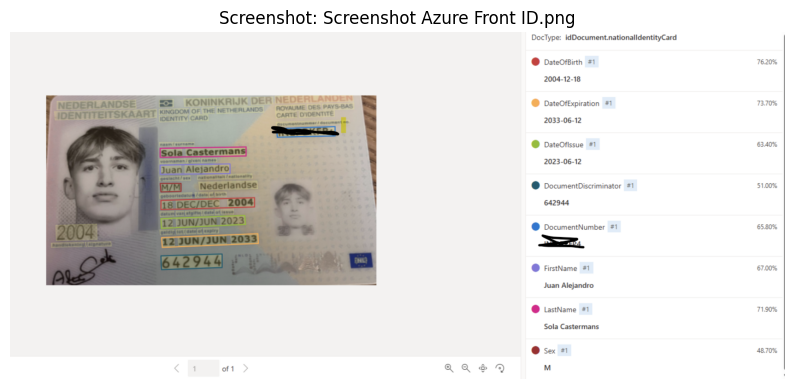

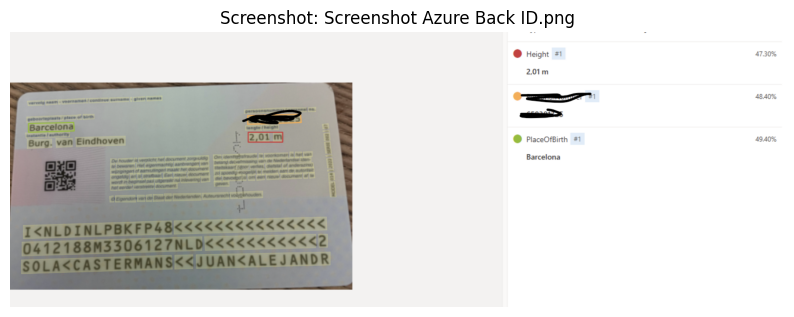

In [ ]:
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
import os
import matplotlib.pyplot as plt
import cv2

# Azure credentials
endpoint = "https://alpayalec1213.cognitiveservices.azure.com/"
key = "3LmBSsqqx9cxjH3abNllYrX6OpBsRqA4QxbmsxC4EoYmg5raJZrjJQQJ99BEACi5YpzXJ3w3AAALACOGQxzy"

# File paths for front and back of ID
image_paths = {
    "Front": "../Text Extraction/Data/IdAlecFront.png",
    "Back": "../Text Extraction/Data/IdAlecBack.png"
}

# Extra screenshots to display at the end
screenshots = [
    "../Text Extraction/Data/Screenshot Azure Front ID.png",
    "../Text Extraction/Data/Screenshot Azure Back ID.png"
]

# Initialize Azure Form Recognizer client
client = DocumentAnalysisClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key)
)

# Analyze each side of the ID
for side, path in image_paths.items():
    if not os.path.exists(path):
        print(f" File not found: {path}")
        continue

    print(f"\nProcessing {side} of ID: {os.path.basename(path)}")

    with open(path, "rb") as f:
        poller = client.begin_analyze_document("prebuilt-idDocument", document=f)
        result = poller.result()

    for doc in result.documents:
        print(f"\n Extracted Fields from {side}:")
        for name, field in doc.fields.items():
            value = field.value if field.value else "N/A"
            confidence = round(field.confidence * 100)
            print(f" - {name}: {value} ({confidence}%)")

# Show the screenshots at the end
for path in screenshots:
    if os.path.exists(path):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb)
        plt.title(f"Screenshot: {os.path.basename(path)}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Screenshot not found: {path}")


#### **Conclusion National Identity**

Tesseract OCR will be used for the text extraction. For more details, visit the Tesseract OCR vs Microsoft Azure document.  

### **1.2 License Plate Text Extraction**

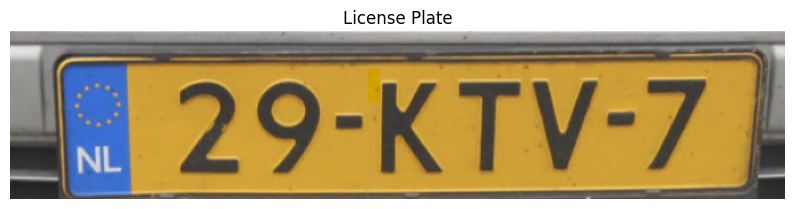

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the image (in BGR format)
image_path = "../Text Extraction/Data/LicensePlateExample1.png"
img = cv2.imread(image_path)

# Convert to RGB for correct display in matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("License Plate")
plt.show()


#### **Tesseract OCR**

As of now, Azure does not offer a dedicated model for license plate recognition. Therefore, for this task, only Tesseract OCR will be used. 

While the overall process is similar to the one used for identity documents, it is simpler in this case, since we are only interested in extracting a single element: the license plate number. Because of this, the OCR configuration is specifically tuned for short, high-contrast alphanumeric text. As previously, the image is first preprocessed to reduce noise and enhance readability before performing text extraction.

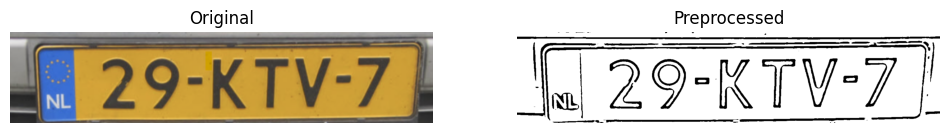

license_plate = '29-KTV-7'


In [ ]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os

image_path = "../Text Extraction/Data/LicensePlateExample1.png"

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found!")

    # Resize
    img = cv2.resize(img, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Bilateral filter to reduce noise while preserving edges
    blur = cv2.bilateralFilter(gray, 11, 17, 17)

    # Adaptive threshold
    processed = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 31, 10
    )
    return img, processed

# Load original + preprocessed
original_img, processed_img = preprocess_image(image_path)

# Show both images
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed_img, cmap='gray')
plt.title("Preprocessed")
plt.axis("off")
plt.show()

# OCR config and extraction
config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'
text = pytesseract.image_to_string(processed_img, config=config).strip()
license_plate = text.replace(" ", "").upper()

# Save result
output_path = "../Text Extraction/Outputs/LicensePlateTextExtraction.txt"
with open(output_path, "w", encoding="utf-8") as f:
    f.write(f"license_plate = '{license_plate}'")

# Print for confirmation
print(f"license_plate = '{license_plate}'")


#### **Conclusion License Plate**

Very few noise, and correct text extraction. For more details visit the Tesseract OCR vs Microsoft Azure document. 

### **1.3 Drivers License Text Exraction**

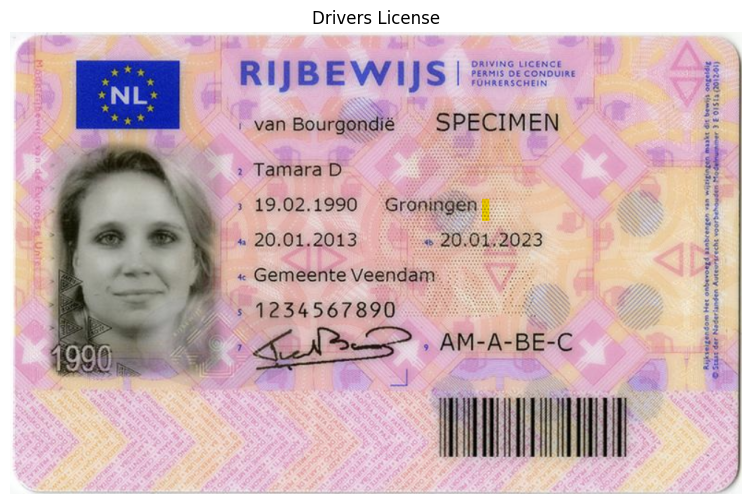

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the image (in BGR format)
image_path = "../Text Extraction/Data/DriversLicenseExample1.png"
img = cv2.imread(image_path)

# Convert to RGB for correct display in matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Drivers License")
plt.show()


### **Tesseract OCR**

This script processes an image of a Dutch driver's license. 

It begins by reading and converting the image to grayscale for preprocessing, which is then displayed for visual confirmation. It then applies regular expressions to identify and extract structured fields such as the license holder's name, date of birth, issue and expiry dates, license number, and vehicle categories. The extracted text is then printed to the console, saved as a plain text file, and the structured data is also stored in JSON format for further use. 

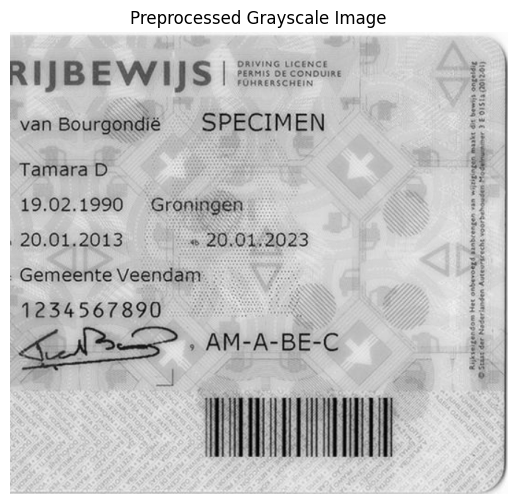


Extracted fields:
first_name: Tamara D
name: TAMARA D VAN BOURGONDIË
date_of_birth: 19.02.1990
issue_date: 20.01.2013
expiry_date: 20,01,2023
license_number: 1234567890
categories: AM-A-BE-C


In [ ]:
import cv2
import pytesseract
import numpy as np
import re
import json
import os
import matplotlib.pyplot as plt

# Input/output paths
image_path = "../Text Extraction/Data/DriversLicenseExample1.png"
output_txt_full = "../Text Extraction/Outputs/DriversLicenseFullOutput.txt"
output_txt_fields = "../Text Extraction/Outputs/DriversLicenseTextExtraction.txt"

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    
    height, width = img.shape[:2]

    # Crop left side (remove photo zone ~32%)
    cropped = img[:, int(width * 0.32):]

    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    return gray

def extract_fields(text):
    fields = {}
    lines = text.splitlines()
    lines = [line.strip() for line in lines if line.strip()]

    # --- NAME ---
    name_line_1 = None
    name_line_2 = None

    for i, line in enumerate(lines):
        if not name_line_1 and re.search(r'\bvan\b\s+[A-Z][a-z]+', line, re.IGNORECASE):
            name_line_1 = line.strip()
        elif not name_line_2 and re.match(r'^[A-Z][a-z]+ [A-Z]\.?$', line):
            name_line_2 = line.strip()

        if name_line_1 and name_line_2:
            full_name = f"{name_line_2} {name_line_1}".replace("__SPECIMEN", "").strip()
            fields["first_name"] = name_line_2.strip()
            fields["name"] = full_name.upper()

    # --- DATES ---
    date_pattern = r"\b\d{2}[\./,-]\d{2}[\./,-]\d{4}\b"
    all_dates = []
    for line in lines:
        found_dates = re.findall(date_pattern, line)
        if len(found_dates) >= 2:
            all_dates.extend(found_dates)
        elif len(found_dates) == 1:
            all_dates.append(found_dates[0])

        if re.search(rf"{date_pattern}\s*[«\-→]\s*{date_pattern}", line):
            found = re.findall(date_pattern, line)
            if len(found) == 2:
                all_dates.extend(found)

    all_dates = list(dict.fromkeys(all_dates))

    if len(all_dates) >= 1:
        fields["date_of_birth"] = all_dates[0]
    if len(all_dates) >= 2:
        fields["issue_date"] = all_dates[1]
    if len(all_dates) >= 3:
        fields["expiry_date"] = all_dates[2]

    # --- LICENSE NUMBER ---
    license_number = re.search(r"\b\d{9,10}\b", text)
    if license_number:
        fields["license_number"] = license_number.group(0)

    # --- CATEGORIES ---
    valid_categories = ['AM', 'A1', 'A', 'BE', 'B', 'C1', 'C', 'D1', 'T']
    found = re.findall(r'\b[A-Z]{1,3}\b', text)
    codes = [c for c in found if c in valid_categories]
    seen = set()
    ordered = [c for c in codes if not (c in seen or seen.add(c))]

    if ordered:
        fields["categories"] = '-'.join(ordered)

    return fields

# --- MAIN ---

processed = preprocess_image(image_path)

# Optional: show preprocessed image
plt.figure(figsize=(10, 6))
plt.imshow(processed, cmap='gray')
plt.title("Preprocessed Grayscale Image")
plt.axis('off')
plt.show()

# OCR config
custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(processed, config=custom_config, lang='nld+eng').strip()

# Extracted fields
fields = extract_fields(text)

# Save full OCR output
with open(output_txt_full, "w", encoding="utf-8") as f:
    f.write(text)

# Save only extracted fields
with open(output_txt_fields, "w", encoding="utf-8") as jf:
    for key, value in fields.items():
        jf.write(f"{key}: {value}\n")

# Print only the extracted fields
print("\nExtracted fields:")
for key, value in fields.items():
    print(f"{key}: {value}")


### **Microsoft Azure**


Extracted Fields:
 - Address: AddressValue(house_number=None, po_box=None, road=None, city=Groningen, state=None, postal_code=None, country_region=None, street_address=, unit=None, city_district=None, state_district=None, suburb=None, house=None, level=None) (62%)
 - DateOfBirth: 1966-07-29 (84%)
 - DateOfExpiration: 2016-10-01 (85%)
 - DateOfIssue: 2006-10-01 (86%)
 - DocumentNumber: 1234567890 (86%)
 - FirstName: Robert-Jan T K (86%)
 - LastName: Klaverbeek Zilverberk (85%)
 - PlaceOfBirth: Groningen (75%)
 - VehicleClassifications: A-BE-C1 AM (32%)


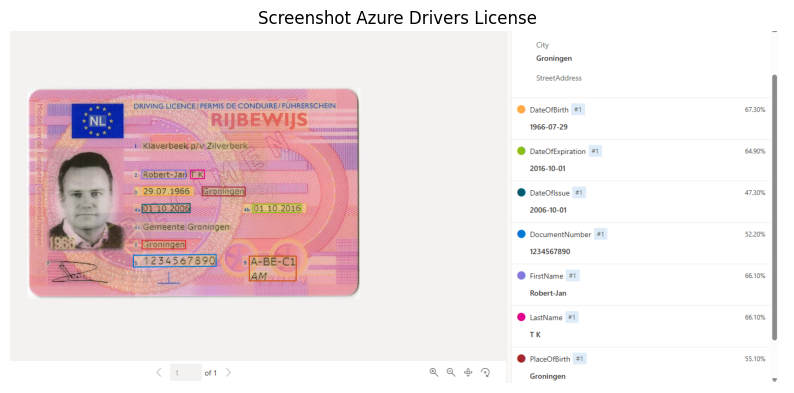

In [ ]:
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential
import os
import matplotlib.pyplot as plt
import cv2

# Azure Form Recognizer credentials
endpoint = "https://alpayalec1213.cognitiveservices.azure.com/"
key = "3LmBSsqqx9cxjH3abNllYrX6OpBsRqA4QxbmsxC4EoYmg5raJZrjJQQJ99BEACi5YpzXJ3w3AAALACOGQxzy"

# Document to analyze
image_path = "../Accident Report/Image.png"

# Screenshot to display
screenshot_path = "../Accident Report/Screenshot Azure DriversLicense.png"

# Create Form Recognizer client
client = DocumentAnalysisClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key)
)

# Analyze image
with open(image_path, "rb") as f:
    poller = client.begin_analyze_document("prebuilt-idDocument", document=f)
    result = poller.result()

# Print results
for doc in result.documents:
    print("Extracted Fields:")
    for name, field in doc.fields.items():
        value = field.value if field.value else "N/A"
        confidence = round(field.confidence * 100)
        print(f" - {name}: {value} ({confidence}%)")

# Display screenshot image
if os.path.exists(screenshot_path):
    img = cv2.imread(screenshot_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.title("Screenshot Azure Drivers License")
    plt.axis('off')
    plt.show()
else:
    print(f" Screenshot not found: {screenshot_path}")


#### **Conclusion Drivers License**
Tesseract OCR will be used for the drivers license. For more details visit the Tesseract OCR vs Micreosoft Azure document. 

## **2. Ollama Model**

In this section, we build an application that completes the remaining sections of the accident report. Since the app cannot be executed within a Jupyter notebook cell, only the results will be imported and shown in this document. The python file where the app is deployed is included, as well as a video demonstration. 

In [24]:
input_pdf_path = "../Text Extraction/Ollama Model Remaining Fields/accident_report_2025-06-01_11-51-33.txt"

with open(input_pdf_path, "r", encoding="utf-8") as f:
    content = f.read()
    print(content)


injury: yes
property_damage: yes
phone_number: 448474784
vat_a: yes
insurer_a: aaa
policy_num: 7788474
agent_a: Max
green_number: 4784752
green_card_until: 2025/17
damage_insured_a: yes
initial_impact_a: Right Middle, Left Middle
visible_damage_a: No
remarks_a: No



## **3. Overlaying the document for Vehicle A**

The process is overlaying an exisiting document, therefore it is essential to first know the exact coordinates are for each field. For this reason, the first step is to make a grid of the pdf, and from there, create the overlay. 

### **3.1 Creating the grid**

This can be opened in the folder submitted, the filename is called: "Accident Report Form with Grid".

In [ ]:
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from PyPDF2 import PdfReader, PdfWriter
import io

# Path to your original PDF
input_pdf_path = "../Text Extraction/Accident Report Form.pdf"
output_pdf_path = "../Text Extraction/Accident Report Form with Grid.pdf"

# Create a transparent overlay with a coordinate grid
packet = io.BytesIO()
c = canvas.Canvas(packet, pagesize=A4)
width, height = A4

# Draw vertical grid lines and X-axis labels
for x in range(0, int(width), 50):
    c.setFont("Helvetica", 6)
    c.drawString(x + 2, 5, str(x))
    c.line(x, 0, x, height)

# Draw horizontal grid lines and Y-axis labels
for y in range(0, int(height), 50):
    c.setFont("Helvetica", 6)
    c.drawString(2, y + 2, str(y))
    c.line(0, y, width, y)

c.save()
packet.seek(0)

# Read original and overlay PDFs
overlay_pdf = PdfReader(packet)
original_pdf = PdfReader(open(input_pdf_path, "rb"))
output_pdf = PdfWriter()

# Apply the overlay to each page of the original PDF
for i, page in enumerate(original_pdf.pages):
    page.merge_page(overlay_pdf.pages[0])
    output_pdf.add_page(page)

# Save the final PDF with grid
with open(output_pdf_path, "wb") as output_file:
    output_pdf.write(output_file)

print(f"✅ Grid overlay added: {output_pdf_path}")


✅ Grid overlay added: Accident Report Form with Grid.pdf


In [ ]:
import io
from PyPDF2 import PdfReader, PdfWriter
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4

# Define paths to the text files
paths = {
    "driver_license": "../Outputs/DriversLicenseTextExtraction.txt",
    "id_alec": "../Outputs/IDAlecTextExtraction.txt",
    "license_plate": "../Outputs/LicensePlateTextExtraction.txt",
    "ollama_fields": "../Ollama Model Remaining Fields/accident_report_2025-06-01_11-51-33.txt"
}

# Function to read text file and convert to dictionary
def parse_text_file_to_dict(path):
    data = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            if ':' in line:
                key, value = line.strip().split(':', 1)
                data[key.strip()] = value.strip()
            elif '=' in line:
                key, value = line.strip().split('=', 1)
                data[key.strip()] = value.strip().strip("'")
    return data

# Parse each file
driver_data = parse_text_file_to_dict(paths["driver_license"])
id_data = parse_text_file_to_dict(paths["id_alec"])
plate_data = parse_text_file_to_dict(paths["license_plate"])
ollama_data = parse_text_file_to_dict(paths["ollama_fields"])

# Merge into one dictionary matching required field names
ocr_data = {
    'date': '24/05/2025',  # placeholder
    'time': '14:30',       # placeholder
    'place': 'Rue Lafayette, Paris',  # placeholder
    'injury': ollama_data.get('injury'),
    'property_damage': ollama_data.get('property_damage'),
    'witnesses': 'No',  # placeholder
    'name_a': id_data.get('IDname'),
    'first_name_a': id_data.get('IDfirst_name'),
    'address_a': id_data.get('nationality'),  # placeholder
    'phone_number': ollama_data.get('phone_number'),
    'vat_a': ollama_data.get('vat_a'),
    'make_a': 'Placeholder Make',  # placeholder
    'registration_a': plate_data.get('license_plate'),
    'insurer_a': ollama_data.get('insurer_a'),
    'policy_num': ollama_data.get('policy_num'),
    'agent_a': ollama_data.get('agent_a'),
    'green_number': ollama_data.get('green_number'),
    'green_card_until': ollama_data.get('green_card_until'),
    'damage_insured_a': ollama_data.get('damage_insured_a'),
    'driver_name_a': driver_data.get('name'),
    'driver_first_name_a': driver_data.get('first_name'),
    'driver_address_a': id_data.get('nationality'),  # placeholder
    'license_no_a': driver_data.get('license_number'),
    'license_issued_by_a': driver_data.get('categories'),  # placeholder
    'valid_from': driver_data.get('issue_date'),
    'valid_to': driver_data.get('expiry_date'),
    'initial_impact_a': ollama_data.get('initial_impact_a'),
    'visible_damage_a': ollama_data.get('visible_damage_a'),
    'remarks_a': ollama_data.get('remarks_a'),
    'signature_a': id_data.get('IDname')
}

# Create the overlay canvas
packet = io.BytesIO()
can = canvas.Canvas(packet, pagesize=A4)

# Refined coordinates for Vehicle A fields
can.drawString(30, 755, ocr_data['date'])
can.drawString(120, 755, ocr_data['time'])
can.drawString(180, 755, ocr_data['place'])
can.drawString(538, 755, ocr_data['injury']) #if statement yes or no
can.drawString(140, 725, ocr_data['property_damage']) #if statement yes or no
can.drawString(170, 725, ocr_data['witnesses']) #if statement, exists or does not exist
s

can.drawString(50, 668, ocr_data['name_a'])
can.drawString(62, 653, ocr_data['first_name_a'])
can.drawString(58, 638, ocr_data['address_a'])
can.drawString(140, 598, ocr_data['phone_number'])

can.drawString(250, 580, ocr_data['vat_a'])  #if statement yes or no

can.drawString(62, 548, ocr_data['make_a'])
can.drawString(140, 535, ocr_data['registration_a'])

can.drawString(150, 518, ocr_data['insurer_a'])
can.drawString(58, 495, ocr_data['policy_num'])

can.drawString(90, 482, ocr_data['agent_a'])
can.drawString(80, 455, ocr_data['green_number']) #if statement exists or does not exist
can.drawString(120, 440, ocr_data['green_card_until'])
can.drawString(185, 415, ocr_data['damage_insured_a']) #if statement yes or no

can.drawString(50, 379, ocr_data['driver_name_a'])
can.drawString(60, 362, ocr_data['driver_first_name_a'])
can.drawString(55, 348, ocr_data['driver_address_a'])
can.drawString(90, 330, ocr_data['license_no_a'])
can.drawString(40, 311, ocr_data['license_issued_by_a'])
can.drawString(59, 295, ocr_data['valid_from'])
can.drawString(145, 295, ocr_data['valid_to'])

can.drawString(150, 280, ocr_data['initial_impact_a']) #separate logic needed, first one if its a car, motor, or bigger car, and then another one where its something like "front" "back" "side-left" "side-right" "back-right" "back-left" front-right "front-left"
can.drawString(35, 150, ocr_data['visible_damage_a']) #two, three lines, how do i do this
can.drawString(35, 98, ocr_data['remarks_a'])
can.drawString(245, 60, ocr_data['signature_a'])

can.save()
packet.seek(0)

# Merge overlay with original
existing_pdf = PdfReader("Accident Report Form.pdf")
overlay_pdf = PdfReader(packet)
output = PdfWriter()

original_page = existing_pdf.pages[0]
original_page.merge_page(overlay_pdf.pages[0])
output.add_page(original_page)

# Save the filled PDF
with open("filled_accident_report.pdf", "wb") as f:
    output.write(f)

In [26]:
import io
from PyPDF2 import PdfReader, PdfWriter
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import A4
from textwrap import wrap

# Define paths to the text files
paths = {
    "driver_license": "../Text Extraction/Outputs/DriversLicenseTextExtraction.txt",
    "id_alec": "../Text Extraction/Outputs/IDAlecTextExtraction.txt",
    "license_plate": "../Text Extraction/Outputs/LicensePlateTextExtraction.txt",
    "ollama_fields": "../Text Extraction/Ollama Model Remaining Fields/accident_report_2025-06-01_11-51-33.txt"
}

# Function to read text file and convert to dictionary
def parse_text_file_to_dict(path):
    data = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            if ':' in line:
                key, value = line.strip().split(':', 1)
                data[key.strip()] = value.strip()
            elif '=' in line:
                key, value = line.strip().split('=', 1)
                data[key.strip()] = value.strip().strip("'")
    return data

# Parse each file
driver_data = parse_text_file_to_dict(paths["driver_license"])
id_data = parse_text_file_to_dict(paths["id_alec"])
plate_data = parse_text_file_to_dict(paths["license_plate"])
ollama_data = parse_text_file_to_dict(paths["ollama_fields"])

# Merge into one dictionary matching required field names
ocr_data = {
    'date': '24/05/2025',  # placeholder
    'time': '14:30',       # placeholder
    'place': 'Rue Lafayette, Paris',  # placeholder
    'injury': ollama_data.get('injury'),
    'property_damage': ollama_data.get('property_damage'),
    'witnesses': 'No',  # placeholder
    'name_a': id_data.get('IDname'),
    'first_name_a': id_data.get('IDfirst_name'),
    'address_a': id_data.get('nationality'),  # placeholder
    'phone_number': ollama_data.get('phone_number'),
    'vat_a': ollama_data.get('vat_a'),
    'make_a': 'Placeholder Make',  # placeholder
    'registration_a': plate_data.get('license_plate'),
    'insurer_a': ollama_data.get('insurer_a'),
    'policy_num': ollama_data.get('policy_num'),
    'agent_a': ollama_data.get('agent_a'),
    'green_number': ollama_data.get('green_number'),
    'green_card_until': ollama_data.get('green_card_until'),
    'damage_insured_a': ollama_data.get('damage_insured_a'),
    'driver_name_a': driver_data.get('name'),
    'driver_first_name_a': driver_data.get('first_name'),
    'driver_address_a': id_data.get('nationality'),  # placeholder
    'license_no_a': driver_data.get('license_number'),
    'license_issued_by_a': driver_data.get('categories'),  # placeholder
    'valid_from': driver_data.get('issue_date'),
    'valid_to': driver_data.get('expiry_date'),
    'initial_impact_a': ollama_data.get('initial_impact_a'),
    'visible_damage_a': ollama_data.get('visible_damage_a'),
    'remarks_a': ollama_data.get('remarks_a'),
    'signature_a': id_data.get('IDname')
}

packet = io.BytesIO()
can = canvas.Canvas(packet, pagesize=A4)

# Date, Time, Place
can.drawString(30, 755, ocr_data['date'])
can.drawString(120, 755, ocr_data['time'])
can.drawString(180, 755, ocr_data['place'])

# Injury checkbox
if ocr_data.get('injury', '').lower() == 'yes':
    can.drawString(531, 755, '✓')  # Yes box
else:
    can.drawString(470, 755, '✓')  # No box

# Property damage checkbox
if ocr_data.get('property_damage', '').lower() == 'yes':
    can.drawString(132, 717, '✓')  # Yes box
else:
    can.drawString(70, 717, '✓')  # No box

# Witnesses: just mark if it exists and is not 'no'
if ocr_data.get('witnesses', '').strip().lower() != 'no':
    can.drawString(170, 725, '✓')

# Personal info
can.drawString(50, 668, ocr_data['name_a'])
can.drawString(62, 653, ocr_data['first_name_a'])
can.drawString(58, 638, ocr_data['address_a'])
can.drawString(140, 598, ocr_data['phone_number'])

# VAT checkbox
if ocr_data.get('vat_a', '').lower() == 'yes':
    can.drawString(185, 575, '✓')
else:
    can.drawString(125,575, '✓')
# Vehicle info
can.drawString(62, 548, ocr_data['make_a'])
can.drawString(140, 535, ocr_data['registration_a'])

# Insurance info
can.drawString(150, 518, ocr_data['insurer_a'])
can.drawString(58, 495, ocr_data['policy_num'])
can.drawString(90, 482, ocr_data['agent_a'])

# Green card: only draw if it exists
if ocr_data.get('green_number'):
    can.drawString(80, 455, ocr_data['green_number'])
can.drawString(120, 440, ocr_data['green_card_until'])

# Damage insured checkbox
if ocr_data.get('damage_insured_a', '').lower() == 'yes':
    can.drawString(185, 411, '✓')
else:
    can.drawString(125,411, '✓')

# Driver info
can.drawString(50, 379, ocr_data['driver_name_a'])
can.drawString(60, 362, ocr_data['driver_first_name_a'])
can.drawString(55, 348, ocr_data['driver_address_a'])
can.drawString(90, 330, ocr_data['license_no_a'])
can.drawString(40, 311, ocr_data['license_issued_by_a'])
can.drawString(59, 295, ocr_data['valid_from'])
can.drawString(145, 295, ocr_data['valid_to'])

# Initial point of impact (parse type and location)
impact_info = ocr_data.get('initial_impact_a', '').split(',')
if len(impact_info) == 2:
    vehicle_type = impact_info[0].strip()
    location = impact_info[1].strip()
    can.drawString(150, 280, f"{vehicle_type} / {location}")

# Visible damage - wrap text into 2–3 lines
damage_lines = wrap(ocr_data.get('visible_damage_a', ''), width=60)
y_pos = 150
for line in damage_lines[:3]:
    can.drawString(35, y_pos, line)
    y_pos -= 12

# Remarks
can.drawString(35, 98, ocr_data['remarks_a'])

# Signature
can.drawString(245, 60, ocr_data['signature_a'])

can.save()
packet.seek(0)

# Merge with original PDF
existing_pdf = PdfReader("Accident Report Form.pdf")
overlay_pdf = PdfReader(packet)
output = PdfWriter()

original_page = existing_pdf.pages[0]
original_page.merge_page(overlay_pdf.pages[0])
output.add_page(original_page)

with open("filled_accident_report.pdf", "wb") as f:
    output.write(f)
